In [15]:
from meta_transformer import transformer
import jax
from jax import random, vmap, grad, jit, value_and_grad
import jax.numpy as jnp
import haiku as hk
from jax import nn
from meta_transformer.mnist import mnist
from meta_transformer import utils
import optax
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
import datasets


rng = random.PRNGKey(42)


def forward(input_chunks, is_training=True):
    t = transformer.Classifier(
        transformer=transformer.Transformer(
            num_heads=3,
            num_layers=2,
            key_size=32,
            dropout_rate=0.1,
        ),
        model_size=128,
        num_classes=10,
    )
    return t(input_chunks, is_training=is_training)


model = hk.transform(forward)


def loss(params, rng, input_chunks, targets, is_training=True):
    logits = model.apply(params, rng, input_chunks, is_training)[:, 0, :]  # [B, C]
    assert logits.shape == targets.shape
    return -jnp.sum(targets * nn.log_softmax(logits, axis=-1), axis=-1).mean()


# # Test
# chunks = random.normal(rng, (5, 30, 512))
# params = model.init(rng, chunks)
# model.apply(params, rng, chunks).shape
# loss(params, rng, chunks, jnp.array([1, 2, 3, 4, 5]))

In [2]:
# Test on MNIST
train_data, train_labels, test_data, test_labels = mnist()

In [3]:
train_labels.shape

(60000, 10)

In [4]:
# split train_data into batches
BATCH_SIZE = 32
SEQ_LEN = 14
CHUNK_SIZE = 784 // SEQ_LEN


train_data = train_data.reshape(-1, BATCH_SIZE, SEQ_LEN, CHUNK_SIZE)
train_labels = train_labels.reshape(-1, BATCH_SIZE, 10)
test_data = test_data.reshape(-1, SEQ_LEN, CHUNK_SIZE)
test_labels = test_labels.reshape(-1, 10)


model = hk.transform(forward)
chunks = train_data[0]
params = model.init(rng, chunks)

# # Test
# print(model.apply(params, rng, chunks).shape)
# loss(params, rng, chunks, train_labels[0])

In [5]:
sum([x.size for x in jax.tree_util.tree_leaves(params)]) / 1e6

0.374218

In [6]:
# training loop
opt = optax.adam(1e-3)
opt_state = opt.init(params)

In [7]:
@jit
def update_fn(params, opt_state, rng, batch):
    inputs, labels = batch
    l, g = value_and_grad(loss)(params, rng, inputs, labels)
    updates, opt_state = opt.update(g, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, l


@partial(jit, static_argnums=4)
def accuracy(params, rng, inputs, one_hot_targets, is_training=True):
    logits = model.apply(params, rng, inputs, is_training)[:, 0, :]
    predictions = jnp.argmax(logits, axis=-1)
    targets = jnp.argmax(one_hot_targets, axis=-1)
    return jnp.mean(predictions == targets)


def val_accuracy(params, rng):
    """Compute accuracy on test set."""
    test_acc = accuracy(params, rng, test_data, test_labels, is_training=False)
    return test_acc

In [8]:
accuracy(params, rng, train_data[0], train_labels[0])

Array(0.09375, dtype=float32)

In [13]:
params.keys()

dict_keys(['classifier', 'classifier/linear', 'classifier/linear_1', 'transformer/layer_norm', 'transformer/layer_norm_1', 'transformer/layer_norm_2', 'transformer/layer_norm_3', 'transformer/layer_norm_4', 'transformer/linear', 'transformer/linear_1', 'transformer/linear_2', 'transformer/linear_3', 'transformer/multi_head_attention/key', 'transformer/multi_head_attention/linear', 'transformer/multi_head_attention/query', 'transformer/multi_head_attention/value', 'transformer/multi_head_attention_1/key', 'transformer/multi_head_attention_1/linear', 'transformer/multi_head_attention_1/query', 'transformer/multi_head_attention_1/value'])

In [9]:
info = []
step = 0
for epoch in range(15):
    print(f"Epoch {epoch}")
    acc = []
    losses = []
    for batch in zip(train_data, train_labels):
        rng, rng_step = random.split(rng)
        step += 1
        params, opt_state, l = update_fn(params, opt_state, rng_step, batch)
        train_acc = accuracy(params, rng_step, *batch)
        acc.append(train_acc) 
        losses.append(l)

    info.append(dict(loss=np.mean(losses), epoch=epoch, step=step, train_acc=np.mean(acc), val_acc=val_accuracy(params, rng)))

info = utils.dict_concatenate(info)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14


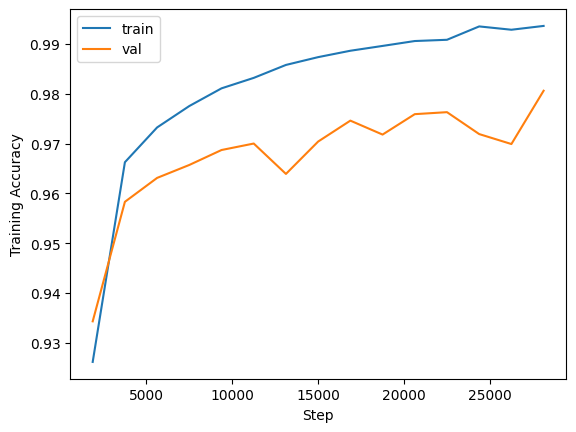

In [10]:
plt.plot([i["step"] for i in info], [i['train_acc'] for i in info], label="train")
plt.plot([i["step"] for i in info], [i['val_acc'] for i in info], label="val")
plt.ylabel("Training Accuracy")
plt.xlabel("Step")
plt.legend()

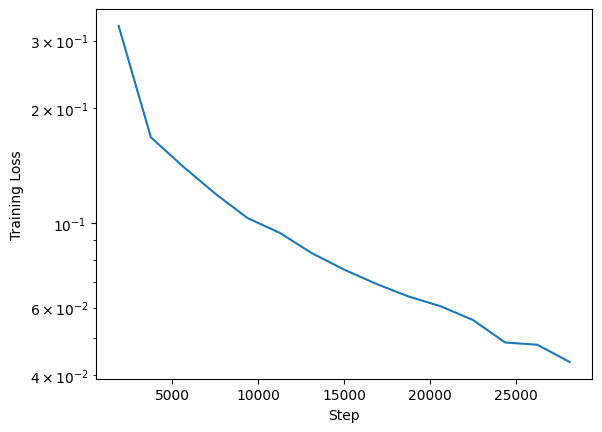

In [11]:
plt.plot([i["step"] for i in info], [i['loss'] for i in info])
plt.ylabel("Training Loss")
plt.xlabel("Step")
plt.yscale("log")


# CIFAR-10

In [29]:
dataset = datasets.load_dataset('cifar10')
dataset = dataset.with_format("jax")
# Split the dataset into train and test sets
train_dataset = dataset['train']
test_dataset = dataset['test']

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 824.68it/s]


In [31]:
import datasets

def load_cifar10():
    # Load the CIFAR-10 dataset using Hugging Face Datasets
    dataset = datasets.load_dataset('cifar10')
    dataset = dataset.with_format("jax")

    # Split the dataset into train and test sets
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    
    # Convert images to float32 and normalize pixel values to the range [0, 1]
    train_images = jnp.array(train_dataset['img'], dtype=jnp.float32) / 255.0
    test_images = jnp.array(test_dataset['img'], dtype=jnp.float32) / 255.0
    
    # One-hot encode labels
    train_labels = jnp.eye(10)[train_dataset['label']]
    test_labels = jnp.eye(10)[test_dataset['label']]
    
    return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_cifar10()

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 871.72it/s]


In [33]:
train_images.shape
train_labels.shape

(50000, 10)